# Random Forest

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Dataframe
path_df = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/df_train.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/Keletso/Documents/Research Paper Classification/2. Feature Engineering/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [3]:
print(features_train.shape)
print(features_test.shape)

(15729, 3000)
(5243, 3000)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [4]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

### Randomized Search Cross Validation

We first need to define the grid:

In [7]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [9]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   n_jobs=-1,
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 222.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

We can see the best hyperparameters resulting from the Random Search:

In [10]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.7730942844427491


We do a more exhaustive search centered around those values:

### Grid Search Cross Validation

In [15]:
bootstrap = [False]
max_depth = [95, 100, 105]
max_features = ['sqrt']
min_samples_leaf = [1, 2]
min_samples_split = [2, 3]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 92.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=8,
                                              verbose=0, warm_start=False),
  

The best hyperparameters turn out to be:

In [17]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.7741604058306043


In [18]:
best_rfc = grid_search.best_estimator_

In [21]:
best_rfc

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

We now know the best random forest model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [22]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

And get the predictions:

In [23]:
rfc_pred = best_rfc.predict(features_test)

#### Training accuracy😊

In [24]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9998728463347956


#### Test accuracy

In [25]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7875262254434484


#### Classification report

In [26]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.72      0.94      0.82      2163
           1       0.88      0.86      0.87      1384
           2       0.84      0.79      0.81      1127
           3       0.83      0.02      0.05       418
           4       0.00      0.00      0.00        99
           5       1.00      0.02      0.04        52

    accuracy                           0.79      5243
   macro avg       0.71      0.44      0.43      5243
weighted avg       0.79      0.79      0.75      5243



C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
df.sample(4)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Title_Parsed,ABSTRACT_Parsed,Article Description,Research Field,Research Field Code
12897,Origin of the Drude peak and of zero sound in ...,"At zero temperature, the charge current oper...",0,1,0,0,0,0,origin drude peak zero sound probe brane ...,zero temperature charge current operator a...,origin drude peak zero sound probe brane ...,Physics,1
20926,An Overview on Application of Machine Learning...,Today's telecommunication networks have beco...,0,0,0,1,0,0,overview application machine learn techniqu...,today telecommunication network become sour...,overview application machine learn techniqu...,Statistics,3
20349,Sketching Linear Classifiers over Data Streams,We introduce a new sub-linear space sketch--...,1,0,0,1,0,0,sketch linear classifiers data stream,introduce new sub-linear space sketch--- w...,sketch linear classifiers data stream intro...,Computer Science,0
8125,Graphene oxide nanosheets disrupt lipid compos...,Graphene has the potential to make a very si...,0,0,0,0,1,0,graphene oxide nanosheets disrupt lipid compos...,graphene potential make significant imp...,graphene oxide nanosheets disrupt lipid compos...,Quantitative Biology,4


#### Confusion matrix

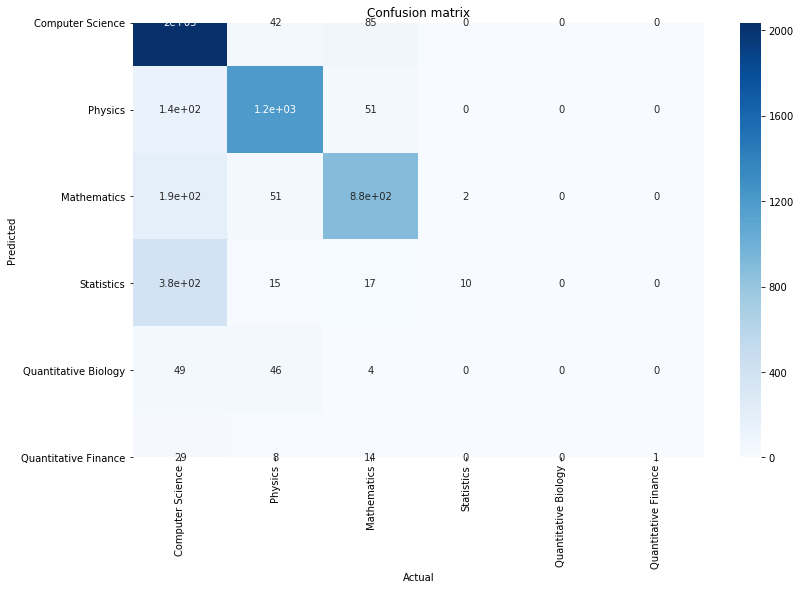

In [31]:
aux_df = df[['Research Field', 'Research Field Code']].drop_duplicates().sort_values('Research Field Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Research Field'].values, 
            yticklabels=aux_df['Research Field'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [32]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7465191684150295

In [33]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.7875262254434484

We'll create a dataset with a model summary to compare models:

In [34]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [35]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.999873,0.787526


In [36]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('Models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)